# Robust Adaptive Importance Sampling for Normal Random Vectors

In [1]:
import numpy as np
import scipy
import time
from matplotlib import pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

### Context

**Goal** : Estimate
$$
    \mathbb{E}[f(G)] \quad G=(G^1, \cdots, G^d) \sim \mathcal{N}(\mathbf{0}_d, I_d)
$$
 - Hypothesis on $f$:
    - $f: \mathbb{R}^d\mapsto \mathbb{R}$
    - $f$ measurable such that $f(G)$ integrable
    - $f(G)$ non zero ie
    $$
    \mathbb{P}(f(G) \neq 0) > 0
    $$
    - $f(G)$ slightly more than square-integrable: 
    $$
    \forall \theta, \quad \mathbb{E}[f^2(G)e^{-\theta G}] < + \infty
    $$
    - Applications: mathematical finance
    - Monte Carlo methods exists but aren't that precise → use variance reduction techniques like importance sampling

### Robust Adaptive Importance Sampling

**Goal** : reduce variance of $M_n(\theta,f)$, an importance sampling estimator of $\mathbb{E}\left[f(G + \theta)e^{-\theta.G - |\theta|^2/2} \right]$

$$
    M_n(\theta,f) \overset{\text{def}}{=} \frac 1n \sum_{i=1} f(G_i+ \theta)e^{-\theta.G_i - \vert \theta\vert^2/2}
$$
    
proven to be an unbiased and convergent estimator of $\mathbb{E}[f(G)]$, with :
$$
    \mathbb{V}[M_n(\theta,f)] = \frac{v^f(\theta) - \mathbb{E}^2[f(G)]}{n}
$$
    
where:

$$
    v^f(\theta) \overset{\text{def}}{=} \mathbb{E}[f^2(G)e^{-\theta G + \vert \theta \vert^2/2}]
$$
    
In our case we want:
$$
    \theta^\star \in \text{Argmin}_\theta v^f(\theta)
$$

This is the Robust Importance Sampling.

In practice, we search for a parameter $\nu^\star$ on a subset of $\mathbb{R}^d$, this latter procedure is called Reduced Robust Importance Sampling.

#### A two phase algorithm

Pratically, the algorithm consists of two steps:
  - the estimation of $\nu^\star$ via Newton's Method using the samples.
  - the computation of the estimator $M_n(\theta,f)$

In [2]:
def RRIS(G, f, nu0, A, max_iter=100, tol=10e-8, verbose=False):
    """
    Implement the Reduced Robust Importance Sampling procedure.
    
     ⋅ G: samples from the Multivariate Gaussian Distribution
     ⋅ f: target function
     ⋅ nu0: initial bet for ν
     ⋅ A: matrix for subset mapping
     . max_iter: the number of iterations for Newton's Iteration
     ⋅ tol: the tolerance to use for Newton's method
    """

    def _printl(*args,**kwargs):
        if verbose:
            print(*args, **kwargs)
    
    d, dp = A.shape

    n, _d = G.shape
    
    assert d == _d, f"A and G do not share dim 0: A.shape={A.shape} G.shape={G.shape}"
    
    nu = nu0
    
    # Caching values
    AT_Gi = A.T @ G.T
    GiT_A = (G @ A).reshape(n, 1, dp)
    AT_A = A.T @ A
    fG2 = f(G)**2
    
    i = 0
    norm_grad = np.inf
    while i < max_iter and norm_grad > tol:
        _printl(f"Iteration {i} / {max_iter}")

        theta = A @ nu

        fi_2_Gi_exp_min_theta_gi = (fG2 * np.exp(-G @ theta))
        assert fi_2_Gi_exp_min_theta_gi.shape == (n,), fi_2_Gi_exp_min_theta_gi.shape

        # ∇ u_n^f(ν)
        num_i = (AT_Gi * fi_2_Gi_exp_min_theta_gi).T
        num_grad = num_i.sum(0)
        denom_grad = fi_2_Gi_exp_min_theta_gi.sum()
        grad = A.T @ theta - num_grad / denom_grad
        assert grad.shape == (dp,), grad.shape

        # ∇² u_n^f(ν)
        H = AT_A + (num_i.reshape(n, dp, 1) @ GiT_A).sum(0) / denom_grad + num_grad @ num_grad.T / denom_grad**2
        assert H.shape == (dp, dp), H.shape
                
        # Newton iterations
        dnu = np.linalg.solve(H, -grad)
        nu += dnu
        
        theta = A @ nu
        obj = (fG2 * np.exp(- G @ theta + 0.5*theta.dot(theta))).mean()
        
        norm_grad = np.linalg.norm(grad)
        _printl(f"||Δν||           = {np.linalg.norm(dnu):0.5f}")
        _printl(f"||∇ u_n^f(ν)||   = {norm_grad:0.5f}")
        _printl(f"u_n^f(ν)         = {obj:0.5f}")
        _printl()
        i += 1
    
    # Computing estimator
    theta_opt = A @ nu
    v_opt = (fG2 * np.exp(- G @ theta_opt + np.linalg.norm(theta_opt)**2/2)).sum() / n
    _printl(f"ν* = {nu}")
    _printl(f"v(Aν*) = {v_opt}")
    a = f(G + theta_opt.T)
    b = np.exp(-G @ theta_opt - (theta_opt ** 2).sum() / 2 )
    RRIS_estimator = (a * b).mean()
    var = (v_opt - RRIS_estimator**2) / n
    
    return RRIS_estimator, nu, var

### Example

Let's take for $f$ a simple gaussian density.

$$
f: G \mapsto \exp\left(- \dfrac{\| G - \mu \|^2}{ 2 \sigma^2} \right)
$$

In [3]:
def gaussian(mu, sigma):
    return lambda G: np.exp(-(((G-mu)/sigma)**2).mean(axis=1) / 2)

We can easily compare the RRIS estimator with the Monte Carlo estimator:

$$
L_n(f) \overset{\text{def}}{=} \frac 1n \sum_{i=1} f(G)
$$


This estimator is unbiased and convergent and has the following variance:

$$
\mathbb{V}\left[L_n(f)\right] = \mathbb{V}\left[\frac{1}{n} \sum_{i=1}^n f(G_i)\right] = \frac{1}{n} \mathbb{V}\left[f(G)\right] = \frac{1}{n} \left[\mathbb{E}\left[f^2(G)\right] - \mathbb{E}\left[f(G)\right]^2 \right]
$$

Which can be estimated by:

$$
\frac{1}{n} \left[\frac{1}{n}\sum_{i=1}^n f^2(G_i) - L_n(f)^2\right]
$$

In [4]:
def monte_carlo(G, f):
    n = G.shape[0]
    mc_est = f(G).mean()
    var_est = ((f(G)**2).mean() - mc_est**2) / n
    return mc_est, var_est

In [5]:
n = 200
d = 1
dp = d
T = 1000

mu = np.random.rand(d)*4-2
mu = 2
sigma = (1/3)**0.5
target = gaussian(mu, sigma)
# Works only for d=1
E = np.exp(- np.linalg.norm(mu)**2 / (sigma**2+1) / 2) / (1 + sigma**(-2)) ** (d*0.5)

nu0 = np.zeros(dp)
A = np.zeros((d, dp))
A[0:dp, 0:dp] = np.eye(dp)

e0, e1 = [], []
v0, v1 = [], []
nus = []
for _ in range(T):
    G = np.random.normal(size=(n,d))
    mc_est, mc_var  = monte_carlo(G, target)
    rris_est, nu, rris_var = RRIS(G[:n//2], target, nu0, A, verbose=False)
    
    e0.append(mc_est)
    e1.append(rris_est)
    v0.append(mc_var)
    v1.append(rris_var)
    nus.append(nu)

e0, e1, v0, v1, nus = map(np.array, [e0, e1, v0, v1, nus])
print(f"Translation mu: {mu} \t Theta: {A @ nus.mean(0)}")
if d==1: print("Expectation:", E)
print(f"Monte Carlo: \tE = {e0.mean()} \tV = {e0.var()} \tVest = {v0.mean()}")
print(f"RRIS: \t\tE = {e1.mean()} \tV = {e1.var()} \tVest = {v1.mean()}")

Translation mu: 2 	 Theta: [1.49901286]
Expectation: 0.11156508007421491
Monte Carlo: 	E = 0.11164716755908352 	V = 0.00031286386062926087 	Vest = 0.0002772059221390292
RRIS: 		E = 0.11141853264488986 	V = 6.516898801359425e-05 	Vest = 6.358149430217119e-05


### Spherical Harmonics — examples

In [6]:
from spherical import H

n = 10000
d = dp = 3
A = np.eye(d)
nu0 = np.zeros(d)

l, m = 2, 1
target = lambda G: np.apply_along_axis(lambda g: H(l, m, g), 1, G)

G = np.random.normal(size=(n,d))
mc_est, mc_var = monte_carlo(G, target)
rris_est, nu, rris_var = RRIS(G[:n//2], target, nu0, A, verbose=False)

print(f"nu: {nu}")
print(f"Monte Carlo: \tE = {mc_est} \tVest = {mc_var}")
print(f"RRIS: \t\tE = {rris_est} tVest = {rris_var}")

nu: [ 0.00466711 -0.00415402  0.0073165 ]
Monte Carlo: 	E = 0.9971626685492107 	Vest = 4.341556968384629e-05
RRIS: 		E = 1.0046235378320703 tVest = 8.700036733031657e-05


### Central Limit Theorem

We have under some conditions, the following Central Limit Theorem:
$$
\sqrt{\frac{n}{v^{f,A}(\nu_\star^{f,A}) - \mathbb{E}^2[f(G)]}}\left[M_n(\theta_n^{f,A}) - \mathbb{E}(f(G)) \right] \overset{\mathcal L}{\longrightarrow} \mathcal{N}_1(0, 1)
$$

In [7]:
T = 1000
n = 10000
d = 2
dp = d

mu = 2
sigma = 0.2
target = gaussian(mu, sigma)

nu0 = np.zeros(dp)
A = np.zeros((d, dp))
A[0:dp, 0:dp] = np.eye(dp)

# RRIS Statistics
rris_mus = np.zeros((T, 1))
rris_sigmas = np.zeros((T, 1))
rris_st = np.zeros((T, 1))

# MC Statistics
mc_mus = np.zeros((T, 1))
mc_sigmas = np.zeros((T, 1))
mc_st = np.zeros((T, 1))

for t in tqdm(range(T)):
    G = np.random.normal(size=(n,d))
    
    start_mc = time.time()
    mc_mu, mc_var = monte_carlo(G, target)
    mc_st[t] = time.time() - start_mc

    start_rris = time.time()
    rris_mus[t], nu_st, rris_sigmas_sq = RRIS(G, target, nu0, A, verbose=False)
    rris_st[t] = time.time() - start_rris

    mc_mus[t], mc_sigmas[t] = mc_mu, np.sqrt(mc_var)
    # If n is small, the variance can be negative by approximation (see the paper, Remark 2.5)
    rris_sigmas[t] = np.sqrt(np.abs(rris_sigmas_sq))

rris_clt_samples = (rris_mus - rris_mus.mean()) / rris_sigmas.mean()

mc_clt_samples = (mc_mus - mc_mus.mean()) / mc_sigmas.mean()

100%|██████████| 1000/1000 [03:15<00:00,  5.12it/s]


In [8]:
print(f"Average estimation time")
print(f"Monte Carlo: {mc_st.mean()} ms")
print(f"RRIS       : {rris_st.mean()} ms")
print("")
print(f"Total estimation time")
print(f"Monte Carlo: {mc_st.sum()} ms")
print(f"RRIS       : {rris_st.sum()} ms")

Average estimation time
Monte Carlo: 0.0017343649864196777 ms
RRIS       : 0.18961000156402588 ms

Total estimation time
Monte Carlo: 1.7343649864196777 ms
RRIS       : 189.61000156402588 ms


Text(0.5, 1.0, 'RRIS — Central Limit Theorem Pictured (T, n)=(1000, 10000)')

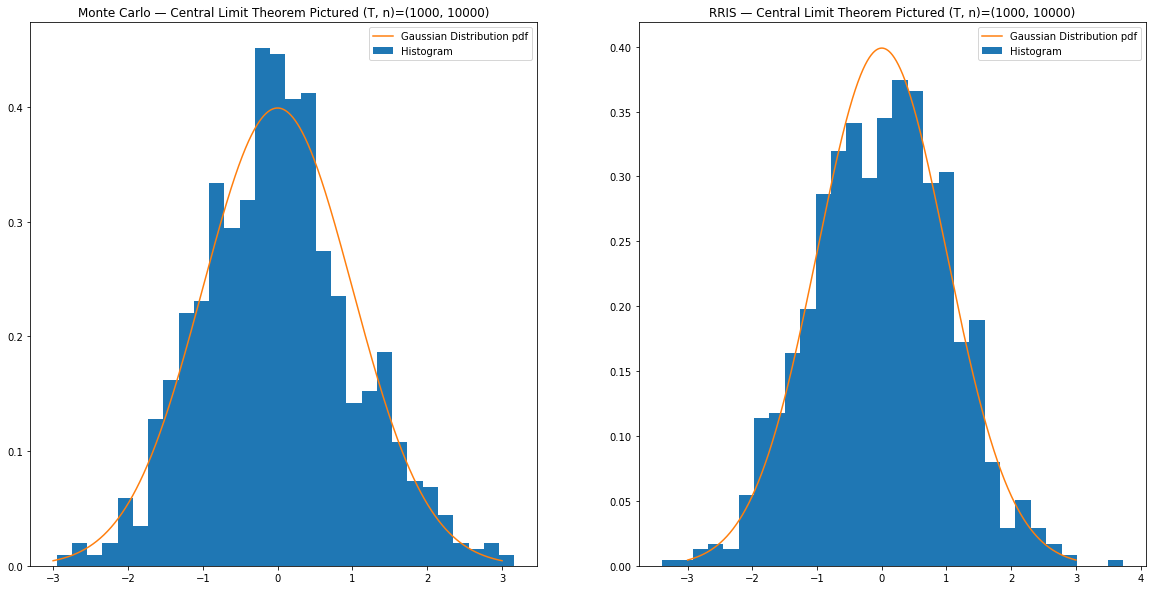

In [9]:
plt.figure(figsize=(20, 10))
t = np.linspace(-3, 3, 1000)

plt.subplot(1, 2, 1)
plt.hist(mc_clt_samples, bins=30, density=True)
plt.plot(t,scipy.stats.norm.pdf(t))
plt.legend(["Gaussian Distribution pdf", "Histogram"])
plt.title(f"Monte Carlo — Central Limit Theorem Pictured (T, n)=({T}, {n})")

plt.subplot(1, 2, 2)
plt.hist(rris_clt_samples, bins=30, density=True)
plt.plot(t,scipy.stats.norm.pdf(t))
plt.legend(["Gaussian Distribution pdf", "Histogram"])
plt.title(f"RRIS — Central Limit Theorem Pictured (T, n)=({T}, {n})")

In [10]:
# I_0.95 Confidence intervals
I_095 = mc_mus.mean() + np.array([-1, 1]) * 1.96 * mc_sigmas.mean()
print(f"MC  : I_0.95 = {mc_mus.mean()} ± {1.96 * mc_sigmas.mean()} = [{mc_mus.mean() - 1.96 * mc_sigmas.mean()}, {mc_mus.mean() + 1.96 * mc_sigmas.mean()}]")

# I_0.95 Confidence intervals
I_095 = rris_mus.mean() + np.array([-1, 1]) * 1.96 * rris_sigmas.mean()
print(f"RRIS: I_0.95 = {rris_mus.mean()} ± {1.96 * rris_sigmas.mean()} = [{rris_mus.mean() - 1.96 * rris_sigmas.mean()}, {rris_mus.mean() + 1.96 * rris_sigmas.mean()}]")

MC  : I_0.95 = 0.0018039393251682951 ± 0.0005516598685740878 = [0.0012522794565942073, 0.002355599193742383]
RRIS: I_0.95 = 0.001823522258506674 ± 8.624977773060097e-05 = [0.001737272480776073, 0.0019097720362372748]
